## Übung 2: Multivariates Lineares Modell inklusive Test der Annahmen 

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.gofplots import qqplot
from sklearn.model_selection import train_test_split

In [2]:
# Daten laden
df = pd.read_csv('./boston.csv')

# Daten vorverarbeiten
df = df.dropna()
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


#### Erklärung der Variablen zu Boston Housing Dataset

Link: https://www.kaggle.com/c/boston-housing/data

#### Beschreibung der Daten

- Der Boston Housing-Datensatz, wurde in den 1970er Jahren von der Boston Standard Metropolitan Statistical Area (SMSA) erhoben
- Einzelne Zeilen: Jede Zeile im Datensatz repräsentiert einen Stadtteil (Tract) in Boston. Es handelt sich um aggregierte Daten für ganze Stadtteile.
- Stadtteile (Tracts): Ein Tract ist ein geographisches Gebiet, das für statistische Zwecke definiert ist. Ein Tract besteht aus mehreren Hundert bis mehreren Tausend Einwohnern. Die Gebiete sind so ausgelegt, dass sie relativ homogene Merkmale aufweisen.

Regressoren:
1) CRIM:  Kriminalitätsrate pro Kopf nach Stadt
2) ZN: Anteil des Wohngebietslandes, das für Grundstücke über 25.000 Quadratfuß ausgewiesen ist.
3) INDUS: Anteil der nicht-gewerblichen Gewerbeflächen pro Stadt
4) CHAS: Charles River-Dummy-Variable (1, wenn der Trakt am Fluss grenzt; 0 ansonsten)
5) NOX: Stickoxidkonzentration (Teile pro 10 Millionen) [parts/10M]
6) RM: Durchschnittliche Anzahl der Zimmer pro Wohnung
7) AGE: Anteil der Eigentümer-Genutzten Einheiten, die vor 1940 gebaut wurden
8) DIS: Gewichtete Entfernungen zu fünf Beschäftigungszentren in Boston
9) RAD: Index der Zugänglichkeit zu radialen Autobahnen
10) TAX: Grundsteuerwert pro $10.000 [$/10k]
11) PTRATIO: Schüler-Lehrer-Verhältnis nach Stadt
12) B: Das Ergebnis der Gleichung B=1000(Bk - 0.63)^2 wobei Bk der Anteil der schwarzen Bevölkerung nach Stadt ist
13) LSTAT: Prozentualer Anteil der Bevölkerung mit niedrigem Einkommen

Abhängigevariable:
1) MEDV: Median-Eigentumswert von Häusern, gemessen in $1.000. [k$]


#### Correlation der Variabeln

In [3]:
df_correl = df.corr()["MEDV"].abs().sort_values(ascending=False)
print(df_correl)

MEDV       1.000000
LSTAT      0.737663
RM         0.695360
PTRATIO    0.507787
INDUS      0.483725
TAX        0.468536
NOX        0.427321
CRIM       0.388305
RAD        0.381626
AGE        0.376955
ZN         0.360445
B          0.333461
DIS        0.249929
CHAS       0.175260
Name: MEDV, dtype: float64


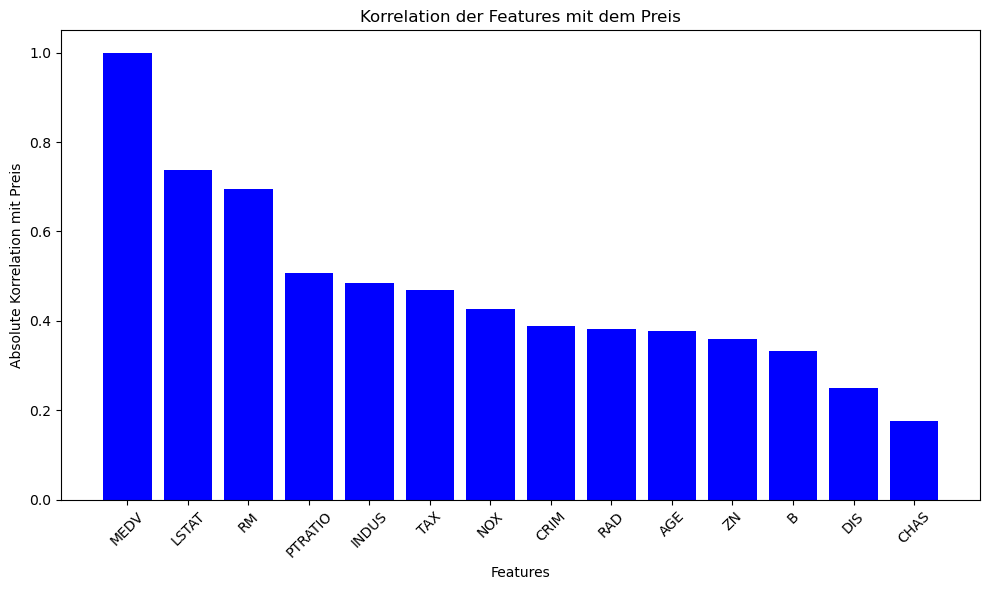

In [4]:
plt.figure(figsize=(10, 6))  # Größe des Plots anpassen
plt.bar(df_correl.index, df_correl.values, color='blue')  # Verwende Index und Werte der Serie
plt.xlabel('Features')  # Beschriftung der X-Achse
plt.ylabel('Absolute Korrelation mit Preis')  # Beschriftung der Y-Achse
plt.title('Korrelation der Features mit dem Preis')  # Titel des Plots
plt.xticks(rotation=45)  # Dreht die X-Achsen-Beschriftungen für bessere Lesbarkeit
plt.tight_layout()  # Passt Layout automatisch an, um Platz zu schaffen
plt.show()

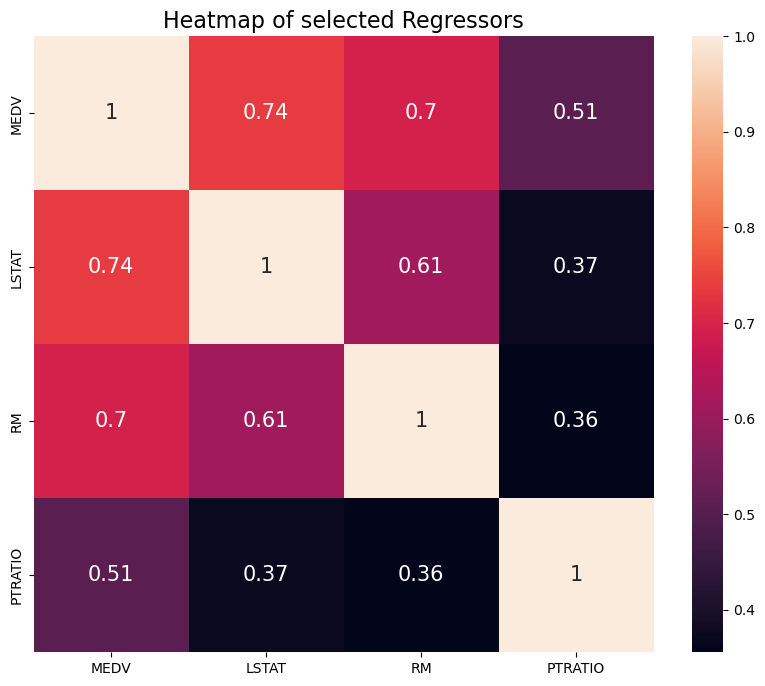

In [5]:
df_selected = df[['MEDV','LSTAT', 'RM', 'PTRATIO']]

# Erstellen der Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_selected.corr().abs(), annot=True, annot_kws={'size': 15}) 
plt.title('Heatmap of selected Regressors', fontsize=16)
  
plt.show() 

Auswahl von 'LSTAT', 'RM', 'PTRATIO' da diese am stärksten mit dem Preis korrelieren. 

In [6]:
df[['MEDV','LSTAT', 'RM', 'PTRATIO']].describe()

,MEDV,LSTAT,RM,PTRATIO
count,506.000000,506.000000,506.000000,506.000000
mean,22.532806,12.653063,6.284634,18.455534
std,9.197104,7.141062,0.702617,2.164946
min,5.000000,1.730000,3.561000,12.600000
25%,17.025000,6.950000,5.885500,17.400000
50%,21.200000,11.360000,6.208500,19.050000
75%,25.000000,16.955000,6.623500,20.200000
max,50.000000,37.970000,8.780000,22.000000


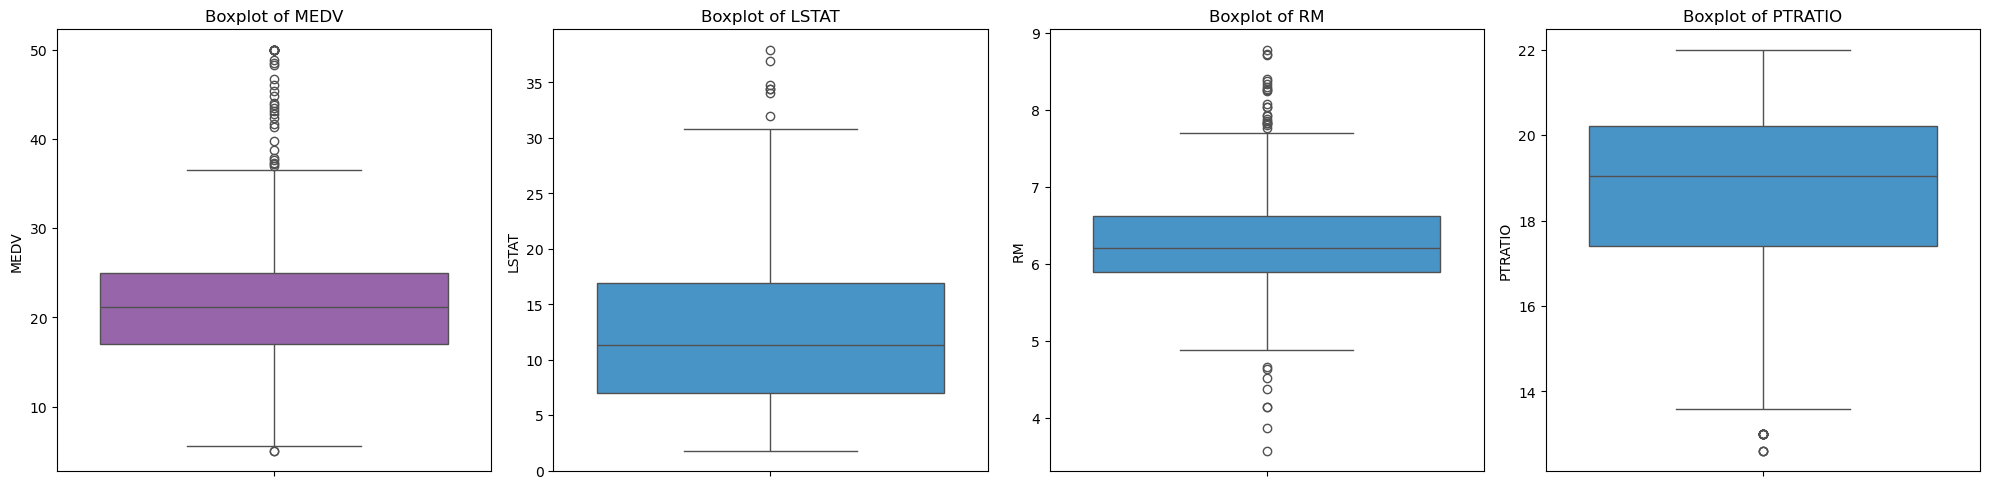

In [7]:
variables = ['MEDV','LSTAT', 'RM', 'PTRATIO']

# Festlegen spezifischer Farben
colors = ['#9b59b6', '#3498db', '#3498db', '#3498db']

# Figur und Achsen erstellen
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Boxplots erstellen
for i, var in enumerate(variables):  # Wir verwenden nur die ersten 4 Variablen für die 4 Boxplots
    sns.boxplot(y=df[var], ax=axes[i], color=colors[i])
    axes[i].set_title(f'Boxplot of {var}')
    axes[i].set_ylabel(var)

# Layout anpassen
plt.tight_layout()
plt.show()

### Regressoren in Bezug auf die abhängige Variable

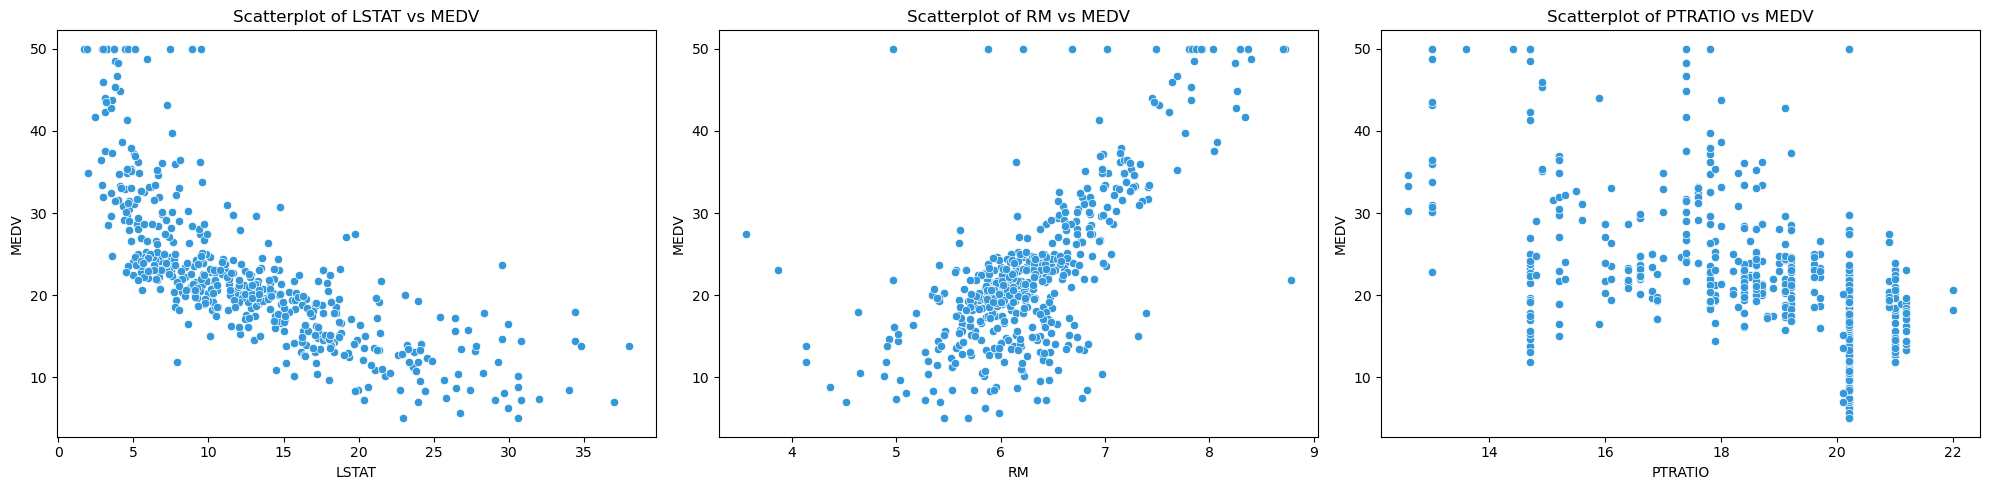

In [8]:
variables = ['LSTAT', 'RM', 'PTRATIO']

# Festlegen spezifischer Farben
colors = ['#3498db', '#3498db', '#3498db']

# Figur und Achsen erstellen
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Boxplots erstellen
for i, var in enumerate(variables):
    sns.scatterplot(y=df['MEDV'], x=df[var], ax=axes[i], color=colors[i])
    axes[i].set_title(f'Scatterplot of {var} vs MEDV')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('MEDV')

# Layout anpassen
plt.tight_layout()
plt.show()

#### Modellentwicklung

In [9]:
# Zielvariable und Prädiktoren definieren

target = 'MEDV'
predictors = ['LSTAT', 'RM', 'PTRATIO']

# Daten für das Modell vorbereiten
X = df[predictors]
y = df[target]
X = sm.add_constant(X)  # Adds a constant term to the predictor

# Modell erstellen und fitten
model = sm.OLS(y, X).fit()

# Modellzusammenfassung anzeigen
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.679
Model:                            OLS   Adj. R-squared:                  0.677
Method:                 Least Squares   F-statistic:                     353.3
Date:                Sun, 09 Jun 2024   Prob (F-statistic):          2.69e-123
Time:                        16:27:05   Log-Likelihood:                -1553.0
No. Observations:                 506   AIC:                             3114.
Df Residuals:                     502   BIC:                             3131.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         18.5671      3.913      4.745      0.0

**R-squared (R²)**: (Güte der Anpassung des Modells).

 Ein R²-Wert von 0.679 zeigt, dass das Modell eine gute Anpassung an die Daten bietet, da ein signifikanter Anteil der Varianz in MEDV durch die Prädiktoren erklärt wird.

**Adj. R-squared**: Anpassung des R²-Werts (Anzahl der Prädiktoren berücksichtigt).

Ein Wert von 0.677, der dem R²-Wert sehr nahe kommt, zeigt, dass das Modell auch nach Berücksichtigung der Anzahl der Prädiktoren gut angepasst ist.



#### Signifikanztests

**F-statistic und Prob (F-statistic)**: Der F-Test prüft, ob das Modell insgesamt signifikant ist.

Ein F-Wert von 353.3 und ein p-Wert von 2.69e-123 zeigen, dass das Modell insgesamt hochsignifikant ist. Dies bedeutet, dass die Prädiktoren gemeinsam eine signifikante Erklärungskraft für die abhängige Variable haben.

**Coefficients**: geschätzte Änderung in der abhängigen Variable für eine Einheit Änderung der jeweiligen unabhängigen Variable.

- LSTAT: coeff: -0.5718 (P-Wert: 0.000)
Anstieg des Anteils der unteren Bevölkerungsschicht (LSTAT) um eine Einheit, ist mit einer durchschnittlichen Abnahme des Medianwerts der Häuser (MEDV) um 0.5718 verbunden. Der p-Wert zeigt, dass dieser Koeffizient signifikant ist.

- RM: coeff: 4.5154 (P-Wert: 0.000)
Anstieg der durchschnittlichen Anzahl der Räume (RM) um eine Einheit, ist mit einer durchschnittlichen Zunahme des Medianwerts der Häuser (MEDV) um 4.5154 verbunden. Der p-Wert zeigt, dass dieser Koeffizient signifikant ist.

- PTRATIO: coeff: -0.9307 (P-Wert: 0.000)
Anstieg des Schüler-Lehrer-Verhältnisses (PTRATIO) um eine Einheit, ist mit einer durchschnittlichen Abnahme des Medianwerts der Häuser (MEDV) um 0.9307 verbunden. Der p-Wert zeigt, dass dieser Koeffizient signifikant ist.

**P>|t| für jeden Koeffizienten**: Der p-Wert für den t-Test der Nullhypothese. p_wert ist ein Maß dafür, das ein Ergebnis durch Zufall zustande gekommen ist. Ein niedriger p-Wert bedeutet, dass es unwahrscheinlich ist, das ein Ergebnis durch Zufall zustande gekommen ist.

Alle p-Werte für die Koeffizienten sind null oder nahe null, was darauf hinweist, dass alle Prädiktoren (LSTAT, RM, PTRATIO) signifikant zur Erklärung der abhängigen Variable (MEDV) beitragen.

#### Test der Modellannahmen

   Feature         VIF
0    const  283.342604
1    LSTAT    1.679425
2       RM    1.653419
3  PTRATIO    1.198101


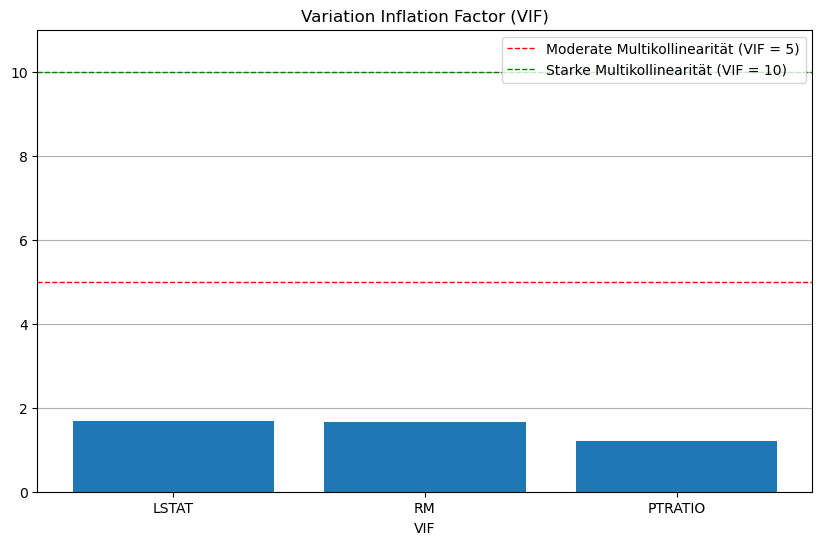

In [10]:
# Multikolinearität mittels Variation Inflation Factor
X = df[['LSTAT', 'RM', 'PTRATIO']]
X = sm.add_constant(X)
# VIF berechnen
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

# Balkendiagramm der VIF-Werte erstellen
plt.figure(figsize=(10, 6))
plt.bar(vif_data['Feature'][1:], vif_data['VIF'][1:])
plt.xlabel('VIF')
plt.title('Variation Inflation Factor (VIF)')
plt.grid(axis='y')
plt.ylim(0, 11)

plt.axhline(y=5, color='r', linestyle='--', linewidth=1, label='Moderate Multikollinearität (VIF = 5)')
plt.axhline(y=10, color='g', linestyle='--', linewidth=1, label='Starke Multikollinearität (VIF = 10)')
plt.legend()

# Diagramm anzeigen
plt.show()

**Nullhypothese**: Es liegt keine Multikolinearität vor

Interpretation des Ergebnisses: <br>
Es liegt keine Multikolinearität zwischen den Regressoren vor, da der VIF für alle Regressoren kleiner als 10 ist

In [11]:
# Strukturbruch mittels CUSUM-Test
from statsmodels.stats.diagnostic import breaks_cusumolsresid

# Anwenden des CUSUM-Tests auf die Residuen
cusum_results = breaks_cusumolsresid(model.resid)

# Ergebnisse anzeigen
print(cusum_results)

(1.5361986172981803, 0.01783369003476366, [(1, 1.63), (5, 1.36), (10, 1.22)])


**Nullhypothese:** Es liegen keine Strukturbrüche vor

Interpretation des Ergebnisses: <br>
P-Wert: 0.0178 kleiner als Signigikanznievau von 0.05 -> Nullhypothese wird abgelehnt. <br>
<br>
Kritischer Wert bei einem Siginifikanz nieveau von 0.05 = 1.36<br>
<br>
CUSUM-Statistik: 1.536 <br>
-> Kritischer Wert für Signifikanzniveau von 0.05 ist gleich 1.36. Wir liegen über dem kritischen Wert was bedeutet, dass die Nullhypothese abgelehnt wird.

Link: https://www.statsmodels.org/dev/generated/statsmodels.stats.diagnostic.breaks_cusumolsresid.html


Goldfeld-Quandt-Test:
(2.627833339883764, 3.8726739186677145e-14, 'increasing')
F-Statistik: 2.627833339883764
p-Wert: 3.8726739186677145e-14


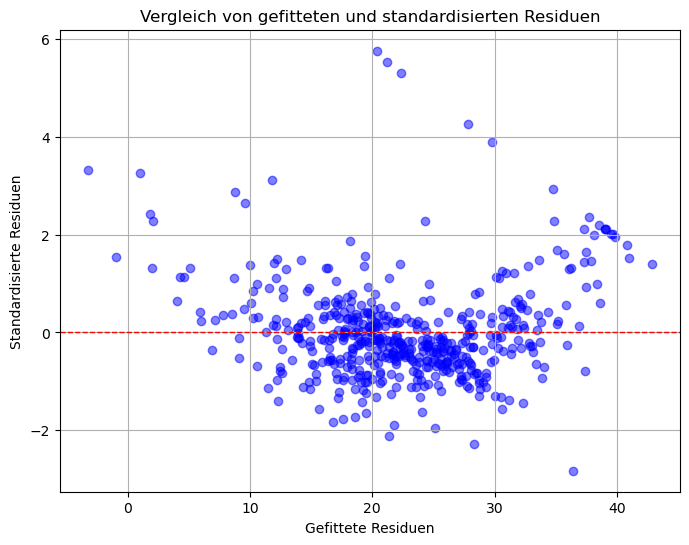

In [12]:
# Test auf Homoskedastizität mittels Goldfeld-Quandt-Test
from statsmodels.stats.diagnostic import het_goldfeldquandt
gq_test = het_goldfeldquandt(y, X, alternative='increasing')

print('Goldfeld-Quandt-Test:')
print(gq_test)
print(f'F-Statistik: {gq_test[0]}')
print(f'p-Wert: {gq_test[1]}')

# Standardisierte Residuen erhalten
standardized_residuals = model.get_influence().resid_studentized_internal

# Gefittete Residuen erhalten
fitted_residuals = model.fittedvalues

# Plot erstellen
plt.figure(figsize=(8, 6))
plt.scatter(fitted_residuals, standardized_residuals,alpha=0.5, color='b')
plt.axhline(y=0, color='r', linestyle='--', linewidth=1)
plt.xlabel('Gefittete Residuen')
plt.ylabel('Standardisierte Residuen')
plt.title('Vergleich von gefitteten und standardisierten Residuen')
plt.grid(True)
plt.show()

alternative increasing -> Es wird auf steigende Heteroskedastizität geprüft. Es wird untersucht, ob die Varianz der Residuen mit zunehmendem Wert der unabhängigen Variable zunimmt <br>

**Nullhypothese**: Es liegt keine Heteroskedastizität in den Residuen vor

Interpretation der Ergebnisse: <br>
F-Statistik: 2.627833339883764 Hoher Wert, indiz für Heteroskedastizität <br>
p-Wert:  3.8726739186677145e-14 kleiner als 0,05 -> Ablehnen der Nullhypothese 
<br>


In [13]:
# Test auf Autokorrelation 1. Ordnung
from statsmodels.stats.stattools import durbin_watson
dw_test = durbin_watson(model.resid)

print('Durbin-Watson-Test:')
print(f'Durbin-Watson-Statistik: {dw_test}')

Durbin-Watson-Test:
Durbin-Watson-Statistik: 0.9012359113980764


**Nullhypothese**: Es liegt keine Autokorrelation vor

Interpretation der Ergebnisse: <br>
Durbin-Watson-Statistik: 0.9012 -> Es liegt eine positive Autokorrelation vor, da der DW-Wert näher an der Null liegt

<br>
Positive Autokorrelation: Frühere Beobachtungen weisen tendenziell ähnliche Muster oder Trends wie spätere Beobachtungen auf.

Jarque-Bera-Test:
Statistik: 1022.1533546876631
p-Wert: 1.1020954264391648e-222


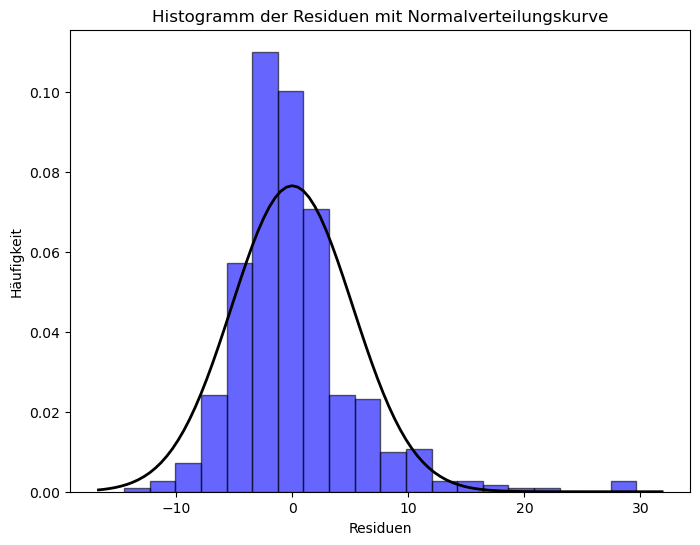

In [14]:
# Test auf Normalverteilung 
from scipy.stats import jarque_bera, norm

# Residuen des Modells erhalten
residuals = model.resid

# Jarque-Bera-Test durchführen
jb_test = jarque_bera(residuals)

print('Jarque-Bera-Test:')
print(f'Statistik: {jb_test[0]}')
print(f'p-Wert: {jb_test[1]}')

# Histogramm der Residuen erstellen
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=20, density=True, alpha=0.6, color='b', edgecolor='black')

# Normalverteilungskurve erstellen
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, np.mean(residuals), np.std(residuals))
plt.plot(x, p, 'k', linewidth=2)

plt.title('Histogramm der Residuen mit Normalverteilungskurve')
plt.xlabel('Residuen')
plt.ylabel('Häufigkeit')

plt.show()

**Nullhypothese**: Die Daten sind Residuen sind Normalverteilt

Interpretation der Ergebnisse: <br>
p-Wert: 1.1020954264391648e-222 kleiner als 0,05 -> Ablehnen der Nullhypothese 

#### Ex-ante Prognose und Prognosefehler

In [28]:
# Daten in Trainings- und Testdatensatz aufteilen
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

# Trainingsdaten für das Modell vorbereiten
X_train = train_data[predictors]
y_train = train_data[target]
X_train = sm.add_constant(X_train)

# Modell auf Trainingsdaten erstellen und fitten
model = sm.OLS(y_train, X_train).fit()

# Testdaten vorbereiten
X_test = test_data[predictors]
y_test = test_data[target]
X_test = sm.add_constant(X_test)

# Ex-ante Prognose durchführen
ex_ante_predictions = model.predict(X_test)

# Prognosefehler berechnen
forecast_error = np.mean((ex_ante_predictions - y_test) ** 2)
print("Ex-ante Prognosefehler:")
print(forecast_error)

# Final Prediction Error (FPE) für das Modell auf den Trainingsdaten
# Anzahl der Beobachtungen
n = model.nobs
# Anzahl der Regressoren + Intercept
k = model.df_model + 1
residual_sum_of_squares = model.ssr
fpe = residual_sum_of_squares / (n - k - 1)
print("Final Prediction Error (FPE):")
print(fpe)

Ex-ante Prognosefehler:
27.114957415580584
Final Prediction Error (FPE):
27.57991296818377


**Ex-ante Prognosefehler**:
- Dieser Wert misst die durchschnittliche Abweichung der Vorhersagen des Modells von den tatsächlichen Werten in den Testdaten. Ein kleinerer Wert deutet auf eine bessere Vorhersagegenauigkeit des Modells hin(MSE).

- **Interpretation**: 27.11, durchschnittliche quadratische Abweichung ist relativ hoch.

**FPE**: 
- Ein Maß zur Bewertung der Modellgenauigkeit, das sowohl die Varianz der Schätzfehler als auch die Anzahl der Prädiktoren im Modell berücksichtigt. Ein kleinerer Wert deutet auf eine bessere Modellgenauigkeit hin.

- **Interpretation**: 27.58, relativ ähnlich du Ex-Ante-Progonosefehler, das bedeutet konstistente Performance auf Trainings- und Testdaten.

Ex-ante Prognosefehler: Vorhersage darüber, wie gut das Modell auf neuen Daten abschneiden wird
<br>
Final Prediciton Error: Wie gut schneidet das Modell auf vorhandenen Daten ab

#### Schätzen unter der Verletzung der Annahmen

Verletzte Annahmen: 
- Strukturbruch -> Wird vernachlässigt, da die Daten nicht in einer Zeitreihe vorliegen
- Autokorrelation
- Keine Normalverteilten Residuen
- Heteroskedastizität


=> Aitken-Schätzung um Autokorrelaiton auszugleichen -> Kann auch die Ursache für die nicht Nomrmalverteilten Residuen sein

Schätzen unter Autokorrelation: 

Cochrane und Orcutt (CORC) - Methode

In [49]:
target = 'MEDV'
predictors = ['LSTAT', 'RM', 'PTRATIO']

# Daten für das Modell vorbereiten
X = df[predictors]
y = df[target]
X = sm.add_constant(X)

# Funktion zur Durchführung der Cochrane-Orcutt-Schätzung
def cochrane_orcutt(X, y, max_iter=100, tol=1e-5):
    # Erste OLS-Schätzung
    model = sm.OLS(y, X).fit()
    rho = 0
    
    for i in range(max_iter):
        # Berechnung der Residuen
        residuals = model.resid
        
        # Schätzung von rho durch Regression der Residuen auf sich selbst
        residuals_lagged = residuals.shift(1).dropna()
        rho_model = sm.OLS(residuals[1:], residuals_lagged).fit()
        rho_new = rho_model.params[0]
        
        # Transformieren der Variablen
        y_transformed = y[1:] - rho_new * y[:-1].values
        X_transformed = X[1:] - rho_new * X[:-1].values
        
        # Indizes der transformierten Variablen anpassen
        y_transformed.index = y.index[1:]
        X_transformed.index = X.index[1:]
        
        # Neue OLS-Schätzung mit transformierten Variablen
        model = sm.OLS(y_transformed, X_transformed).fit()
        
        # Überprüfen der Konvergenz
        if abs(rho_new - rho) < tol:
            break
        
        rho = rho_new
    
    return model, rho

# Durchführung der Cochrane-Orcutt-Schätzung
co_model, estimated_rho = cochrane_orcutt(X, y)

# Modellzusammenfassung anzeigen
print(co_model.summary())
print(f"Geschätztes rho: {estimated_rho}")

# Durbin-Watson Test zur Überprüfung der Autokorrelation in den Residuen des neuen Modells
dw_statistic = durbin_watson(co_model.resid)
print(f"Durbin-Watson-Statistik: {dw_statistic}")

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.691
Model:                            OLS   Adj. R-squared:                  0.689
Method:                 Least Squares   F-statistic:                     373.4
Date:                Sun, 09 Jun 2024   Prob (F-statistic):          2.60e-127
Time:                        17:33:48   Log-Likelihood:                -1579.9
No. Observations:                 505   AIC:                             3168.
Df Residuals:                     501   BIC:                             3185.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.1817      3.935      4.875      0.0

C:\Users\luiss\AppData\Local\Temp\ipykernel_24464\541900157.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rho_new = rho_model.params[0]


Das R^2 steigt, aber die Durbin-Watson Statistik nährt sich weiter Null an, was für eine Verstärkung der Autokorrelation spricht -> Erstellen eines GLS-Modell mit White Standardfehler um auch auch die Heteroskedastizität im Modell zu berücksichtigen

Schätzen unter Heteroskedastizität und Autokorrelation: 

Verwenden eines GLS-Modells mit White Standardfehler 

In [79]:
target = 'MEDV'
predictors = ['LSTAT', 'RM', 'PTRATIO']

# Daten für das Modell vorbereiten
X = df[predictors]
y = df[target]
X = sm.add_constant(X)

# Modell mit OLS schätzen
model_ols = sm.OLS(y, X)
results_ols = model_ols.fit()

# Berechnung des White Standardfehlers
results_robust = results_ols.get_robustcov_results(cov_type='HC0')

# GLS-Modell erstellen und schätzen
gls_model = sm.GLS(y, X)
results_gls = gls_model.fit()

# Modellzusammenfassungen anzeigen
print(results_robust.summary())
print(results_gls.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.679
Model:                            OLS   Adj. R-squared:                  0.677
Method:                 Least Squares   F-statistic:                     215.7
Date:                Sun, 09 Jun 2024   Prob (F-statistic):           7.09e-90
Time:                        18:25:02   Log-Likelihood:                -1553.0
No. Observations:                 506   AIC:                             3114.
Df Residuals:                     502   BIC:                             3131.
Df Model:                           3                                         
Covariance Type:                  HC0                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         18.5671      5.454      3.404      0.0